This notebook is simpified version of the final project in the [How to Win a Data Science Competition: Learn from Top Kagglers](https://www.coursera.org/learn/competitive-data-science) course. Simplified means without ensembling.

#### Pipline
* load data
* heal data and remove outliers
* work with shops/items/cats objects and features
* create matrix as product of item/shop pairs within each month in the train set
* get monthly sales for each item/shop pair in the train set and merge it to the matrix
* clip item_cnt_month by (0,20)
* append test to the matrix, fill 34 month nans with zeros
* merge shops/items/cats to the matrix
* add target lag features
* add mean encoded features
* add price trend features
* add month
* add days
* add months since last sale/months since first sale features
* cut first year and drop columns which can not be calculated for the test set
* select best features
* set validation strategy 34 test, 33 validation, less than 33 train
* fit the model, predict and clip targets for the test set

# Part 1, perfect features

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)

In [2]:
!ls data

item_categories.csv	      sales_train.csv	     test.csv
items.csv		      sample_submission.csv
knn_feats_minkowski_test.npy  shops.csv


In [3]:
items = pd.read_csv('data/items.csv')
shops = pd.read_csv('data/shops.csv')
cats = pd.read_csv('data/item_categories.csv')
train = pd.read_csv('data/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('data/test.csv').set_index('ID')

## Outliers

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

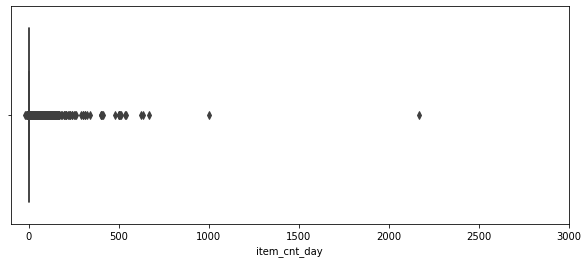

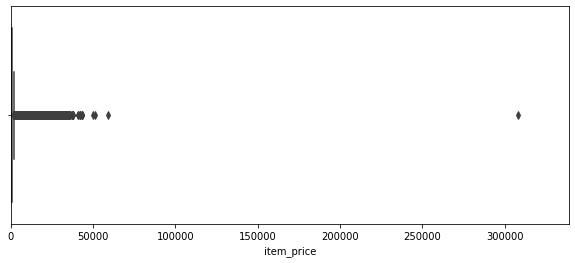

In [4]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [5]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

There is one item with price below zero. Fill it with median.

In [6]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

Several shops are duplicates of each other (according to its name). Fix train and test set.

In [7]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Shops/Cats/Items preprocessing
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [8]:
shops.head(2)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


In [9]:
cats.head(2)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [10]:
items.head(2)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


In [11]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

## Monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. 
In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and <b>extend it with zero sales</b> for each unique pair within the month. This way train data will be similar to test data.

In [12]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [13]:
%%time
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

CPU times: user 6.66 s, sys: 554 ms, total: 7.21 s
Wall time: 7.21 s


Aggregate train set by shop/item pairs to calculate target aggreagates, then <b>clip(0,20)</b> target value. This way train target will be similar to the test predictions.

<i>I use floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later. If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.</i>

In [14]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [15]:
%%time
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0))
#                                 .clip(0,20) # NB clip target here
#                                 .astype(np.float16))

CPU times: user 2.41 s, sys: 480 ms, total: 2.89 s
Wall time: 2.89 s


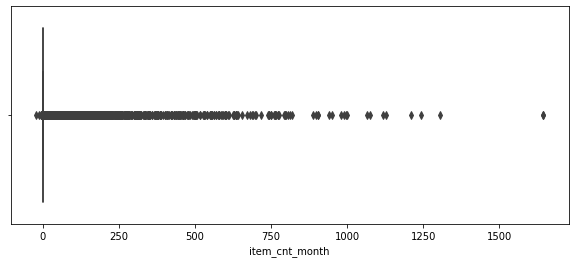

In [16]:
plt.figure(figsize=(10,4))
# plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=matrix.item_cnt_month)

## Test set
To use time tricks append test pairs to the matrix.

In [17]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [18]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.044194936752319336

## Shops/Items/Cats features

In [19]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

2.5615787506103516

## Traget lags

In [20]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [21]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

19.602515697479248

In [22]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,20,55,13,2,1.0,0.0,0.0,0.0,NaN
11128000,34,45,16188,0.0,20,64,14,42,0.0,0.0,NaN,NaN,NaN
11128001,34,45,15757,0.0,20,55,13,2,0.0,0.0,0.0,0.0,0.0
11128002,34,45,19648,0.0,20,40,11,4,0.0,0.0,0.0,0.0,NaN


## Mean encoded features

In [23]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

6.4414122104644775

In [24]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

22.635373830795288

In [25]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

23.36367917060852

In [26]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

7.299272060394287

In [27]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

7.587519407272339

In [28]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

7.663727283477783

In [29]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

7.83553409576416

In [30]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

7.676076412200928

In [31]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

11.87193751335144

In [32]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

7.728000640869141

In [33]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

7.817093372344971

In [34]:
matrix.to_pickle('data_new.pkl')

## Trend features

Price trend for the last six months.

In [ ]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

Last month shop revenue trend

In [ ]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

## Special features

In [ ]:
matrix['month'] = matrix['date_block_num'] % 12

Number of days in a month. There are no leap years.

In [ ]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only. I use programing approach.

<i>Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.</i>

In [ ]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

In [ ]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

Months since the first sale for each shop/item pair and for item only.

In [ ]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

## Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [ ]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

Producing lags brings a lot of nulls.

In [ ]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

In [ ]:
matrix.columns

In [ ]:
matrix.info()

In [ ]:
# NB clip target here
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .clip(0,20) 
                                .astype(np.float16))

In [ ]:
matrix.to_pickle('data_new.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# Part 2, xgboost

In [3]:
data = pd.read_pickle('data.pkl')

Select perfect features

In [4]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [5]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [6]:
del data
gc.collect();

In [7]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[19:17:55] WARNING: /workspace/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.15143	validation_1-rmse:1.11694
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10762	validation_1-rmse:1.08392
[2]	validation_0-rmse:1.06571	validation_1-rmse:1.05302
[3]	validation_0-rmse:1.03242	validation_1-rmse:1.02733
[4]	validation_0-rmse:1.00470	validation_1-rmse:1.00850
[5]	validation_0-rmse:0.97947	validation_1-rmse:0.99005
[6]	validation_0-rmse:0.95821	validation_1-rmse:0.97509
[7]	validation_0-rmse:0.93972	validation_1-rmse:0.96128
[8]	validation_0-rmse:0.92408	validation_1-rmse:0.95111
[9]	validation_0-rmse:0.91121	validation_1-rmse:0.94314
[10]	validation_0-rmse:0.90040	validation_1-rmse:0.93633
[11]	va

304.514164686203

In [15]:
!python3 -m pip install hyperopt

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 964 kB 815 kB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [19]:
!python3 -m pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.2 MB 397 kB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [27]:
import lightgbm
from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
# Define searched space
hyper_space = {'objective': 'regression',
               'metric':'rmse',
               'boosting':'gbdt',
#                'n_estimators': hp.choice('n_estimators', [25, 40, 50, 75, 100, 250, 500]),
               'max_depth':  hp.choice('max_depth', [3, 5, 8, 10, 12, 15]),
               'num_leaves': hp.choice('num_leaves', [25, 50, 75, 100, 125, 150, 225, 250, 350, 400, 500]),
               'subsample': hp.choice('subsample', [.3, .5, .7, .8, .9, 1]),
               'colsample_bytree': hp.choice('colsample_bytree', [.5, .6, .7, .8, .9, 1]),
               'learning_rate': hp.choice('learning_rate', [.01, .001, .05, .1, .2]),
               'reg_alpha': hp.choice('reg_alpha', [.1, .2, .3, .4, .5, .6, .7]),
               'reg_lambda':  hp.choice('reg_lambda', [.1, .2, .3, .4, .5, .6]), 
                # 'bagging_fraction': hp.choice('bagging_fraction', [.5, .6, .7, .8, .9, 1]),
               'feature_fraction':  hp.choice('feature_fraction', [.6, .7, .8, .9, 1]), 
               'bagging_frequency':  hp.choice('bagging_frequency', [.3, .4, .5, .6, .7, .8, .9]),                  
               'min_child_samples': hp.choice('min_child_samples', [10, 20, 30, 40])}

In [21]:
def rmse(y_pred, y):
    return np.sqrt(np.mean(np.square(y - y_pred)))

In [30]:
lgtrain = lightgbm.Dataset(X_train, label=Y_train)
lgval = lightgbm.Dataset(X_valid, label=Y_valid)

def evaluate_metric(params):
    
    model_lgb = lightgbm.train(params, lgtrain, 1000, 
                          valid_sets=[lgtrain, lgval], early_stopping_rounds=100, 
                          verbose_eval=300)

    pred = model_lgb.predict(X_valid, num_iteration=1000)

    score = rmse(pred, Y_valid)
    
    print(score, params)
 
    return {
        'loss': score,
        'status': STATUS_OK,
        'stats_running': STATUS_RUNNING
    }

In [31]:
# Trail
trials = Trials()

# Set algoritm parameters
algo = partial(tpe.suggest, 
               n_startup_jobs=-1)

# Seting the number of Evals
MAX_EVALS= 200

# Fit Tree Parzen Estimator
best_vals = fmin(fn=evaluate_metric, space=hyper_space, verbose=1,
                 algo=algo, max_evals=MAX_EVALS, trials=trials)

# Print best parameters
best_params = space_eval(hyper_space, best_vals)


  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]
                                                    Training until validation scores don't improve for 100 rounds

  0%|          | 0/200 [00:03<?, ?trial/s, best loss=?]
                                                    Early stopping, best iteration is:
[21]	training's rmse: 0.778524	valid_1's rmse: 0.917374

  0%|          | 0/200 [00:27<?, ?trial/s, best loss=?]
                                                    0.9173742285440434

  0%|          | 0/200 [00:27<?, ?trial/s, best loss=?]
                                                    {'bagging_frequency': 0.9, 'boosting': 'gbdt', 'colsample_bytree': 0.6, 'feature_fraction': 1, 'learning_rate': 0.2, 'max_depth': 12, 'metric': 'rmse', 'min_child_samples': 20, 'num_leaves': 150, 'objective': 'regression', 'reg_alpha': 0.1, 'reg_lambda': 0.2, 'subsample': 1}

  0%|          | 1/200 [00:27<1:31:12, 27.50s/trial, best loss: 0.9173742285440434]
                               

  3%|▎         | 6/200 [10:09<6:08:07, 113.86s/trial, best loss: 0.9067793484419511]
                                                                                 Early stopping, best iteration is:
[406]	training's rmse: 0.840911	valid_1's rmse: 0.921408

  3%|▎         | 6/200 [10:33<6:08:07, 113.86s/trial, best loss: 0.9067793484419511]
                                                                                 0.9214080626766782

  3%|▎         | 6/200 [10:34<6:08:07, 113.86s/trial, best loss: 0.9067793484419511]
                                                                                 {'bagging_frequency': 0.6, 'boosting': 'gbdt', 'colsample_bytree': 0.5, 'feature_fraction': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'metric': 'rmse', 'min_child_samples': 30, 'num_leaves': 500, 'objective': 'regression', 'reg_alpha': 0.3, 'reg_lambda': 0.5, 'subsample': 0.8}

  4%|▎         | 7/200 [10:34<5:15:41, 98.14s/trial, best loss: 0.9067793484419511] 
                        

  6%|▌         | 12/200 [18:10<5:26:41, 104.26s/trial, best loss: 0.9067793484419511]
                                                                                  Training until validation scores don't improve for 100 rounds

  6%|▌         | 12/200 [18:10<5:26:41, 104.26s/trial, best loss: 0.9067793484419511]
                                                                                  Early stopping, best iteration is:
[61]	training's rmse: 0.79328	valid_1's rmse: 0.911591

  6%|▌         | 12/200 [18:50<5:26:41, 104.26s/trial, best loss: 0.9067793484419511]
                                                                                  0.9115909078783013

  6%|▌         | 12/200 [18:50<5:26:41, 104.26s/trial, best loss: 0.9067793484419511]
                                                                                  {'bagging_frequency': 0.6, 'boosting': 'gbdt', 'colsample_bytree': 1, 'feature_fraction': 0.6, 'learning_rate': 0.05, 'max_depth': 10, 'metric': 'rmse', '

Training until validation scores don't improve for 100 rounds                    

 12%|█▏        | 23/200 [38:37<4:50:19, 98.41s/trial, best loss: 0.9048186227889994]
                                                                                 [300]	training's rmse: 0.904619	valid_1's rmse: 0.956682

 12%|█▏        | 23/200 [39:13<4:50:19, 98.41s/trial, best loss: 0.9048186227889994]
                                                                                 [600]	training's rmse: 0.885562	valid_1's rmse: 0.944896

 12%|█▏        | 23/200 [39:50<4:50:19, 98.41s/trial, best loss: 0.9048186227889994]
                                                                                 [900]	training's rmse: 0.87481	valid_1's rmse: 0.937027

 12%|█▏        | 23/200 [40:26<4:50:19, 98.41s/trial, best loss: 0.9048186227889994]
                                                                                 Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.870848

 18%|█▊        | 35/200 [51:52<2:40:54, 58.51s/trial, best loss: 0.9048186227889994]
                                                                                 Training until validation scores don't improve for 100 rounds

 18%|█▊        | 35/200 [51:52<2:40:54, 58.51s/trial, best loss: 0.9048186227889994]
                                                                                 [300]	training's rmse: 1.08857	valid_1's rmse: 1.06871

 18%|█▊        | 35/200 [52:29<2:40:54, 58.51s/trial, best loss: 0.9048186227889994]
                                                                                 [600]	training's rmse: 1.02503	valid_1's rmse: 1.02729

 18%|█▊        | 35/200 [53:05<2:40:54, 58.51s/trial, best loss: 0.9048186227889994]
                                                                                 [900]	training's rmse: 0.98432	valid_1's rmse: 1.00183

 18%|█▊        | 35/200 [53:42<2:40:54, 58.51s/trial, best loss: 0.9048186227889994]
                    

 20%|██        | 41/200 [58:03<2:10:09, 49.11s/trial, best loss: 0.9048186227889994]
                                                                                 Training until validation scores don't improve for 100 rounds

 20%|██        | 41/200 [58:04<2:10:09, 49.11s/trial, best loss: 0.9048186227889994]
                                                                                 [300]	training's rmse: 0.847221	valid_1's rmse: 0.925238

 20%|██        | 41/200 [58:41<2:10:09, 49.11s/trial, best loss: 0.9048186227889994]
                                                                                 Early stopping, best iteration is:
[288]	training's rmse: 0.847934	valid_1's rmse: 0.924094

 20%|██        | 41/200 [58:52<2:10:09, 49.11s/trial, best loss: 0.9048186227889994]
                                                                                 0.9240937388656257

 20%|██        | 41/200 [58:52<2:10:09, 49.11s/trial, best loss: 0.9048186227889994]
                 

 23%|██▎       | 46/200 [1:08:18<2:54:42, 68.07s/trial, best loss: 0.9048186227889994]
                                                                                   0.9416881942406787

 23%|██▎       | 46/200 [1:08:19<2:54:42, 68.07s/trial, best loss: 0.9048186227889994]
                                                                                   {'bagging_frequency': 0.6, 'boosting': 'gbdt', 'colsample_bytree': 0.5, 'feature_fraction': 0.9, 'learning_rate': 0.01, 'max_depth': 15, 'metric': 'rmse', 'min_child_samples': 40, 'num_leaves': 350, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.6, 'subsample': 1}

 24%|██▎       | 47/200 [1:08:19<4:13:49, 99.54s/trial, best loss: 0.9048186227889994]
                                                                                   Training until validation scores don't improve for 100 rounds

 24%|██▎       | 47/200 [1:08:20<4:13:49, 99.54s/trial, best loss: 0.9048186227889994]
                                        

 28%|██▊       | 57/200 [1:34:01<5:54:35, 148.78s/trial, best loss: 0.9048186227889994]
                                                                                    Training until validation scores don't improve for 100 rounds

 28%|██▊       | 57/200 [1:34:01<5:54:35, 148.78s/trial, best loss: 0.9048186227889994]
                                                                                    [300]	training's rmse: 0.864966	valid_1's rmse: 0.932579

 28%|██▊       | 57/200 [1:34:32<5:54:35, 148.78s/trial, best loss: 0.9048186227889994]
                                                                                    [600]	training's rmse: 0.849939	valid_1's rmse: 0.92691

 28%|██▊       | 57/200 [1:35:02<5:54:35, 148.78s/trial, best loss: 0.9048186227889994]
                                                                                    [900]	training's rmse: 0.841451	valid_1's rmse: 0.926025

 28%|██▊       | 57/200 [1:35:32<5:54:35, 148.78s/trial, best loss: 0.904818

0.9047051993416964                                                                  

 34%|███▎      | 67/200 [2:00:53<5:35:07, 151.18s/trial, best loss: 0.9047051993416964]
                                                                                    {'bagging_frequency': 0.9, 'boosting': 'gbdt', 'colsample_bytree': 0.8, 'feature_fraction': 0.9, 'learning_rate': 0.01, 'max_depth': 10, 'metric': 'rmse', 'min_child_samples': 10, 'num_leaves': 350, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'subsample': 0.9}

 34%|███▍      | 68/200 [2:00:53<5:35:49, 152.64s/trial, best loss: 0.9047051993416964]
                                                                                    Training until validation scores don't improve for 100 rounds

 34%|███▍      | 68/200 [2:00:53<5:35:49, 152.64s/trial, best loss: 0.9047051993416964]
                                                                                    [300]	training's rmse: 0.78029	valid_1's rmse: 0.9050

 39%|███▉      | 78/200 [2:26:17<5:27:22, 161.00s/trial, best loss: 0.9039042903249872]
                                                                                    Training until validation scores don't improve for 100 rounds

 39%|███▉      | 78/200 [2:26:18<5:27:22, 161.00s/trial, best loss: 0.9039042903249872]
                                                                                    Early stopping, best iteration is:
[12]	training's rmse: 0.776102	valid_1's rmse: 0.916273

 39%|███▉      | 78/200 [2:26:50<5:27:22, 161.00s/trial, best loss: 0.9039042903249872]
                                                                                    0.9162731916016408

 39%|███▉      | 78/200 [2:26:50<5:27:22, 161.00s/trial, best loss: 0.9039042903249872]
                                                                                    {'bagging_frequency': 0.8, 'boosting': 'gbdt', 'colsample_bytree': 1, 'feature_fraction': 0.9, 'learning_rate': 0.2, 'max_depth': 12, 'me

 44%|████▍     | 88/200 [2:50:12<3:14:37, 104.26s/trial, best loss: 0.9039042903249872]
                                                                                    0.937621480187813

 44%|████▍     | 88/200 [2:50:20<3:14:37, 104.26s/trial, best loss: 0.9039042903249872]
                                                                                    {'bagging_frequency': 0.5, 'boosting': 'gbdt', 'colsample_bytree': 0.9, 'feature_fraction': 0.6, 'learning_rate': 0.001, 'max_depth': 10, 'metric': 'rmse', 'min_child_samples': 10, 'num_leaves': 500, 'objective': 'regression', 'reg_alpha': 0.7, 'reg_lambda': 0.4, 'subsample': 0.5}

 44%|████▍     | 89/200 [2:50:20<6:29:12, 210.38s/trial, best loss: 0.9039042903249872]
                                                                                    Training until validation scores don't improve for 100 rounds

 44%|████▍     | 89/200 [2:50:20<6:29:12, 210.38s/trial, best loss: 0.9039042903249872]
                               

Training until validation scores don't improve for 100 rounds                       

 50%|████▉     | 99/200 [3:11:21<3:29:16, 124.33s/trial, best loss: 0.9039042903249872]
                                                                                    [300]	training's rmse: 0.869726	valid_1's rmse: 0.932598

 50%|████▉     | 99/200 [3:12:11<3:29:16, 124.33s/trial, best loss: 0.9039042903249872]
                                                                                    [600]	training's rmse: 0.849504	valid_1's rmse: 0.926701

 50%|████▉     | 99/200 [3:12:52<3:29:16, 124.33s/trial, best loss: 0.9039042903249872]
                                                                                    [900]	training's rmse: 0.835706	valid_1's rmse: 0.919592

 50%|████▉     | 99/200 [3:13:34<3:29:16, 124.33s/trial, best loss: 0.9039042903249872]
                                                                                    Did not meet early stopping. Best iteration is:
[100

 55%|█████▍    | 109/200 [3:29:34<1:44:24, 68.84s/trial, best loss: 0.9039042903249872]
                                                                                    0.9195391712774695

 55%|█████▍    | 109/200 [3:29:37<1:44:24, 68.84s/trial, best loss: 0.9039042903249872]
                                                                                    {'bagging_frequency': 0.9, 'boosting': 'gbdt', 'colsample_bytree': 0.8, 'feature_fraction': 0.9, 'learning_rate': 0.01, 'max_depth': 5, 'metric': 'rmse', 'min_child_samples': 10, 'num_leaves': 400, 'objective': 'regression', 'reg_alpha': 0.7, 'reg_lambda': 0.6, 'subsample': 0.8}

 55%|█████▌    | 110/200 [3:29:37<2:29:18, 99.54s/trial, best loss: 0.9039042903249872]
                                                                                    Training until validation scores don't improve for 100 rounds

 55%|█████▌    | 110/200 [3:29:37<2:29:18, 99.54s/trial, best loss: 0.9039042903249872]
                                

 60%|█████▉    | 119/200 [3:51:07<2:43:37, 121.20s/trial, best loss: 0.9039042903249872]
                                                                                     0.9958714368844136

 60%|█████▉    | 119/200 [3:51:08<2:43:37, 121.20s/trial, best loss: 0.9039042903249872]
                                                                                     {'bagging_frequency': 0.9, 'boosting': 'gbdt', 'colsample_bytree': 0.8, 'feature_fraction': 0.8, 'learning_rate': 0.001, 'max_depth': 3, 'metric': 'rmse', 'min_child_samples': 10, 'num_leaves': 250, 'objective': 'regression', 'reg_alpha': 0.7, 'reg_lambda': 0.2, 'subsample': 1}

 60%|██████    | 120/200 [3:51:08<2:39:25, 119.56s/trial, best loss: 0.9039042903249872]
                                                                                     Training until validation scores don't improve for 100 rounds

 60%|██████    | 120/200 [3:51:08<2:39:25, 119.56s/trial, best loss: 0.9039042903249872]
                          

 62%|██████▎   | 125/200 [3:59:29<1:38:14, 78.59s/trial, best loss: 0.9039042903249872]
                                                                                    0.9396597001275642

 62%|██████▎   | 125/200 [3:59:31<1:38:14, 78.59s/trial, best loss: 0.9039042903249872]
                                                                                    {'bagging_frequency': 0.7, 'boosting': 'gbdt', 'colsample_bytree': 0.6, 'feature_fraction': 0.9, 'learning_rate': 0.01, 'max_depth': 15, 'metric': 'rmse', 'min_child_samples': 10, 'num_leaves': 350, 'objective': 'regression', 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.9}

 63%|██████▎   | 126/200 [3:59:31<1:57:11, 95.02s/trial, best loss: 0.9039042903249872]
                                                                                    Training until validation scores don't improve for 100 rounds

 63%|██████▎   | 126/200 [3:59:31<1:57:11, 95.02s/trial, best loss: 0.9039042903249872]
                               

 65%|██████▌   | 130/200 [4:07:21<1:51:39, 95.70s/trial, best loss: 0.9039042903249872]
                                                                                    {'bagging_frequency': 0.3, 'boosting': 'gbdt', 'colsample_bytree': 0.8, 'feature_fraction': 0.9, 'learning_rate': 0.1, 'max_depth': 12, 'metric': 'rmse', 'min_child_samples': 30, 'num_leaves': 25, 'objective': 'regression', 'reg_alpha': 0.6, 'reg_lambda': 0.5, 'subsample': 0.9}

 66%|██████▌   | 131/200 [4:07:21<1:25:42, 74.53s/trial, best loss: 0.9039042903249872]
                                                                                    Training until validation scores don't improve for 100 rounds

 66%|██████▌   | 131/200 [4:07:22<1:25:42, 74.53s/trial, best loss: 0.9039042903249872]
                                                                                    [300]	training's rmse: 0.779946	valid_1's rmse: 0.91137

 66%|██████▌   | 131/200 [4:08:59<1:25:42, 74.53s/trial, best loss: 0.90390429032498

 70%|███████   | 141/200 [4:27:39<1:31:32, 93.09s/trial, best loss: 0.9034371353029375]
                                                                                    [300]	training's rmse: 0.777244	valid_1's rmse: 0.905664

 70%|███████   | 141/200 [4:29:57<1:31:32, 93.09s/trial, best loss: 0.9034371353029375]
                                                                                    Early stopping, best iteration is:
[276]	training's rmse: 0.782683	valid_1's rmse: 0.905331

 70%|███████   | 141/200 [4:30:27<1:31:32, 93.09s/trial, best loss: 0.9034371353029375]
                                                                                    0.9053314124857386

 70%|███████   | 141/200 [4:30:29<1:31:32, 93.09s/trial, best loss: 0.9034371353029375]
                                                                                    {'bagging_frequency': 0.4, 'boosting': 'gbdt', 'colsample_bytree': 0.7, 'feature_fraction': 1, 'learning_rate': 0.01, 'max_depth': 10, 'metri

 73%|███████▎  | 146/200 [4:47:43<2:43:53, 182.10s/trial, best loss: 0.9034371353029375]
                                                                                     0.9037338937277921

 73%|███████▎  | 146/200 [4:47:44<2:43:53, 182.10s/trial, best loss: 0.9034371353029375]
                                                                                     {'bagging_frequency': 0.4, 'boosting': 'gbdt', 'colsample_bytree': 0.7, 'feature_fraction': 0.9, 'learning_rate': 0.01, 'max_depth': 10, 'metric': 'rmse', 'min_child_samples': 10, 'num_leaves': 400, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.2, 'subsample': 1}

 74%|███████▎  | 147/200 [4:47:44<2:32:29, 172.63s/trial, best loss: 0.9034371353029375]
                                                                                     Training until validation scores don't improve for 100 rounds

 74%|███████▎  | 147/200 [4:47:45<2:32:29, 172.63s/trial, best loss: 0.9034371353029375]
                          

Early stopping, best iteration is:                                                   
[295]	training's rmse: 0.819992	valid_1's rmse: 0.91911

 78%|███████▊  | 157/200 [5:15:19<1:55:45, 161.51s/trial, best loss: 0.9034371353029375]
                                                                                     0.9191095479021328

 78%|███████▊  | 157/200 [5:15:20<1:55:45, 161.51s/trial, best loss: 0.9034371353029375]
                                                                                     {'bagging_frequency': 0.4, 'boosting': 'gbdt', 'colsample_bytree': 0.7, 'feature_fraction': 0.9, 'learning_rate': 0.05, 'max_depth': 5, 'metric': 'rmse', 'min_child_samples': 10, 'num_leaves': 500, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.2, 'subsample': 1}

 79%|███████▉  | 158/200 [5:15:20<1:32:10, 131.69s/trial, best loss: 0.9034371353029375]
                                                                                     Training until validation scores don

 82%|████████▏ | 163/200 [5:23:05<1:05:59, 107.03s/trial, best loss: 0.9034371353029375]
                                                                                     Training until validation scores don't improve for 100 rounds

 82%|████████▏ | 163/200 [5:23:06<1:05:59, 107.03s/trial, best loss: 0.9034371353029375]
                                                                                     [300]	training's rmse: 0.812264	valid_1's rmse: 0.908377

 82%|████████▏ | 163/200 [5:24:47<1:05:59, 107.03s/trial, best loss: 0.9034371353029375]
                                                                                     Early stopping, best iteration is:
[302]	training's rmse: 0.811886	valid_1's rmse: 0.908316

 82%|████████▏ | 163/200 [5:25:16<1:05:59, 107.03s/trial, best loss: 0.9034371353029375]
                                                                                     0.9083155407214053

 82%|████████▏ | 163/200 [5:25:17<1:05:59, 107.03s/trial, best loss: 0

 86%|████████▋ | 173/200 [5:51:41<55:25, 123.15s/trial, best loss: 0.9026607656143669]
                                                                                   [900]	training's rmse: 0.924936	valid_1's rmse: 0.952141

 86%|████████▋ | 173/200 [5:53:08<55:25, 123.15s/trial, best loss: 0.9026607656143669]
                                                                                   Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.912037	valid_1's rmse: 0.944502

 86%|████████▋ | 173/200 [5:53:36<55:25, 123.15s/trial, best loss: 0.9026607656143669]
                                                                                   0.9445019784902343

 86%|████████▋ | 173/200 [5:53:39<55:25, 123.15s/trial, best loss: 0.9026607656143669]
                                                                                   {'bagging_frequency': 0.4, 'boosting': 'gbdt', 'colsample_bytree': 0.7, 'feature_fraction': 0.8, 'learning_rate': 0.001, 'max_depth': 8

 90%|████████▉ | 179/200 [6:00:01<29:40, 84.80s/trial, best loss: 0.9026607656143669] 
                                                                                  Training until validation scores don't improve for 100 rounds

 90%|████████▉ | 179/200 [6:00:01<29:40, 84.80s/trial, best loss: 0.9026607656143669]
                                                                                  [300]	training's rmse: 0.789024	valid_1's rmse: 0.907364

 90%|████████▉ | 179/200 [6:01:52<29:40, 84.80s/trial, best loss: 0.9026607656143669]
                                                                                  Early stopping, best iteration is:
[249]	training's rmse: 0.802169	valid_1's rmse: 0.90615

 90%|████████▉ | 179/200 [6:02:08<29:40, 84.80s/trial, best loss: 0.9026607656143669]
                                                                                  0.9061495806666892

 90%|████████▉ | 179/200 [6:02:09<29:40, 84.80s/trial, best loss: 0.9026607656143669]
        

 92%|█████████▏| 184/200 [6:16:16<51:56, 194.77s/trial, best loss: 0.9026607656143669]
                                                                                   Early stopping, best iteration is:
[34]	training's rmse: 0.837077	valid_1's rmse: 0.930838

 92%|█████████▏| 184/200 [6:16:45<51:56, 194.77s/trial, best loss: 0.9026607656143669]
                                                                                   0.9308378486449318

 92%|█████████▏| 184/200 [6:16:46<51:56, 194.77s/trial, best loss: 0.9026607656143669]
                                                                                   {'bagging_frequency': 0.6, 'boosting': 'gbdt', 'colsample_bytree': 0.7, 'feature_fraction': 0.6, 'learning_rate': 0.05, 'max_depth': 15, 'metric': 'rmse', 'min_child_samples': 20, 'num_leaves': 150, 'objective': 'regression', 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 1}

 92%|█████████▎| 185/200 [6:16:46<36:21, 145.41s/trial, best loss: 0.9026607656143669]
           

 98%|█████████▊| 195/200 [6:38:28<11:19, 135.90s/trial, best loss: 0.9026607656143669]
                                                                                   Training until validation scores don't improve for 100 rounds

 98%|█████████▊| 195/200 [6:38:29<11:19, 135.90s/trial, best loss: 0.9026607656143669]
                                                                                   Early stopping, best iteration is:
[21]	training's rmse: 0.770583	valid_1's rmse: 0.933527

 98%|█████████▊| 195/200 [6:39:12<11:19, 135.90s/trial, best loss: 0.9026607656143669]
                                                                                   0.9335269292370982

 98%|█████████▊| 195/200 [6:39:12<11:19, 135.90s/trial, best loss: 0.9026607656143669]
                                                                                   {'bagging_frequency': 0.7, 'boosting': 'gbdt', 'colsample_bytree': 1, 'feature_fraction': 0.9, 'learning_rate': 0.1, 'max_depth': 15, 'metric': '

In [37]:
model_lgb = lightgbm.train(best_params, lgtrain, 1000, 
                      valid_sets=[lgtrain, lgval], early_stopping_rounds=500, 
                      verbose_eval=300)

lgb_pred = model_lgb.predict(X_test).clip(0, 20)

Training until validation scores don't improve for 500 rounds
[300]	training's rmse: 0.77353	valid_1's rmse: 0.903285
[600]	training's rmse: 0.739502	valid_1's rmse: 0.914145
Early stopping, best iteration is:
[278]	training's rmse: 0.77851	valid_1's rmse: 0.902661


In [40]:
import matplotlib.pyplot as plt
# retrieve performance metrics
results = model_lgb.evals_result_
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('rmse')
plt.title('XGBoost rmse')
plt.show()

AttributeError: 'Booster' object has no attribute 'evals_result_'

In [42]:
lightgbm.plot_metric(model_lgb)

TypeError: booster must be dict or LGBMModel.

In [44]:
Y_pred = model_lgb.predict(X_valid).clip(0, 20)
Y_test = model_lgb.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

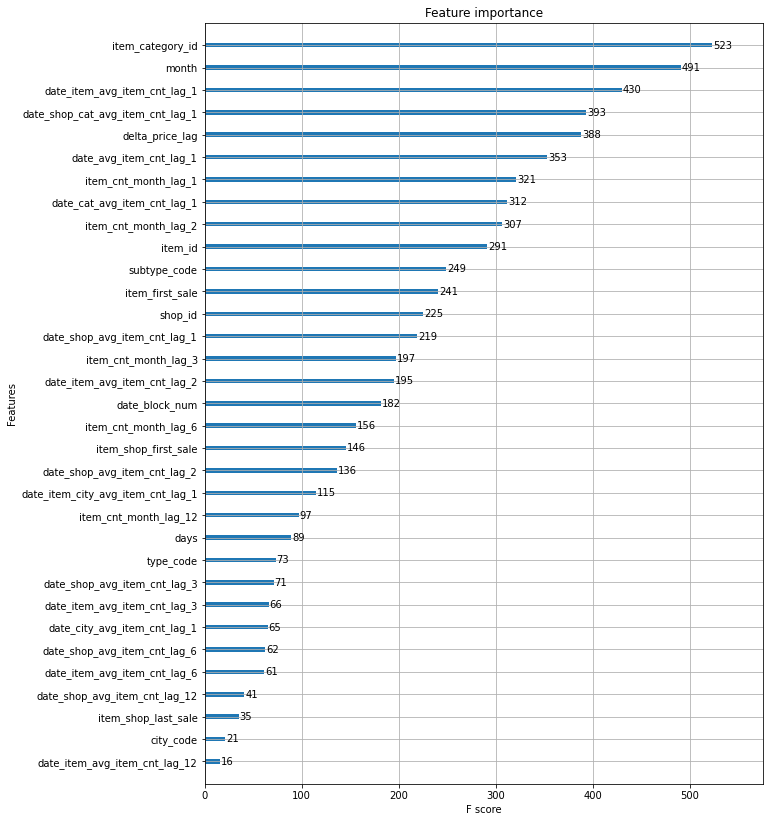

In [13]:
plot_features(model, (10,14))